In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.ringtrap_python.potentials import HarmonicTrapPotential, MutualCoulombPotential, PointChargePotential, LocalHarmonicPotential1D, InverseSquarePotential1D
from src.ringtrap_python.molecular_dynamics import sim_leapfrog
from src.ringtrap_python.eigenmodes import get_ring_eq_pos, get_linear_eq_pos

# Harmonic Oscillators with Coulomb Force

In [9]:
# physical constants 

ensemble_properties = {
    "n": 2,
    "charge": 10,
    "mass": 5
}

n = ensemble_properties["n"]
w = np.array([5 * 2*np.pi, 5.1 * 2*np.pi])
dist = 1
d = np.array([-dist, dist])

In [10]:
potentials = [
        LocalHarmonicPotential1D(w),
        InverseSquarePotential1D(d)
    ]

In [11]:
# initial conditions
r_0 = get_linear_eq_pos(ensemble_properties, dist, potentials=potentials, method="BFGS")
print(r_0)
v_0 = np.array([0, 5])

[-0.00501658  0.00482178]


In [20]:
T = 1e2
dt = 1e-3

r_sim, v_sim, a_sim = sim_leapfrog(T, dt, r_0, v_0, ensemble_properties, potentials=potentials, language="python", dims=1)
t_sim = np.linspace(0, T, int(T/dt)+1)

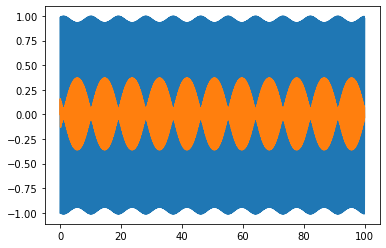

In [21]:
for i in range(n):
    plt.plot(t_sim, r_sim[:,i])
plt.show()

# Ringtrap Simulation

In [14]:
M_Yb = 2.8733965e-25
e = 1.60217883e-19

ensemble_properties = {
    "n": 1,
    "charge": e,
    "mass": M_Yb,
}
n = ensemble_properties["n"]

# trap_radius = (40 * 1e-6) / (2*np.pi) # m, trap radius
trap_radius = 1e-3
wr = 9 * 2*np.pi*1e6
wz = 10 * 2*np.pi*1e6

point_charge_position = np.array([-trap_radius, 0, -200 * 1e-6])
point_charge = e

In [9]:
potentials = [
            HarmonicTrapPotential(trap_radius, wr, wz), 
            MutualCoulombPotential(100*trap_radius),
        ]
perturbed_potentials = [
            HarmonicTrapPotential(trap_radius, wr, wz), 
            MutualCoulombPotential(100*trap_radius),
            PointChargePotential(point_charge_position, point_charge)
        ]

In [15]:
r_eq = get_ring_eq_pos(ensemble_properties,
                      offset=0,
                      potentials=potentials, 
                      initial_radius=trap_radius,
                      method="BFGS")

In [16]:
# initial conditions

# random displacements from equilibrium
r_0 = np.copy(r_eq) # .reshape(3*n) + np.random.normal(loc=5e-9, scale=5e-9, size=r_eq.size)
v_0 = np.zeros(3*n)

# tangential velocity
v_mag = 1000
for i in range(n):
    v_0[i] = -v_mag * np.sin(2*np.pi*(i/n))
    v_0[n+i] = v_mag * np.cos(2*np.pi*(i/n))
    v_0[2*n+i] = 0

In [38]:
T = 2e-4
dt = 1e-10

r_sim, v_sim, a_sim = sim_leapfrog(T, dt, r_0, v_0, ensemble_properties, potentials=perturbed_potentials, language="c++")
t_sim = np.linspace(0, T, int(T/dt)+1)

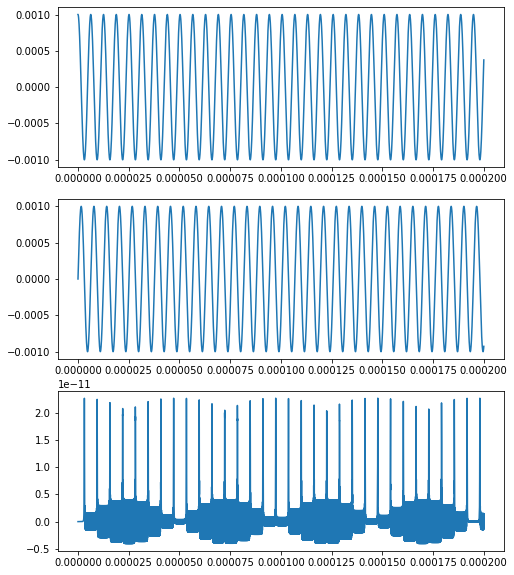

In [39]:
fig, ax = plt.subplots(3, figsize=(8, 10))
for i in range(n):
    ax[0].plot(t_sim, r_sim[:,i])
    ax[1].plot(t_sim, r_sim[:,i+n])
    ax[2].plot(t_sim, r_sim[:,i+2*n])
plt.show()

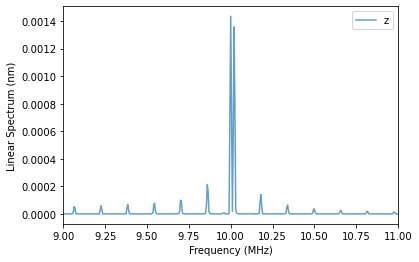

In [40]:
# FFT with windowing and linear spectral density
from scipy.signal import welch, butter, sosfilt

n_tsteps = int(T/dt)

# np.abs(rfftn(np.sin(np.unwrap(r_sim[:,0,0]))))

# sos = butter(10, 1e5, fs=(1/dt), btype="highpass", output="sos")
# r_filt = sosfilt(sos, r_sim[:,0,0])
# plt.plot(np.linspace(0,T,n_tsteps+1), r_filt)

dims = {
        # 0: "x", 
        # 1: "y", 
        2: "z",
        }
for i in dims:
    freq, Pxx_spec = welch(r_sim[:,i+0], fs=(1/dt), window="hann", scaling="spectrum", nperseg=n_tsteps)
    lin_spec = Pxx_spec ** 0.5
    plt.plot(freq / 1e6, lin_spec * 1e9, label=dims[i], alpha=0.7)

plt.xlim(9, 11)
# plt.xticks(np.arange(0, 2, 0.1))
# plt.ylim(0, 100)

plt.xlabel("Frequency (MHz)")
plt.ylabel("Linear Spectrum (nm)")
plt.legend()
plt.show()